# Pré-processamento e Análise da Conectividade

## Autor: Bruno Aristimunha e Luciane Aparecida Moscaleski

Salientamos que essa é uma análise preliminar. Desse modo, escolhas metodológicas adotadas aqui não devem ser tomadas como absolutas, podendo ser posteriormente re-adequada/corrigidas. Além disso, não marcamos o sinal na granularidade necessária para estudar o fenômeno do arremesso, e sim uma sequência de 20 arremessos.

### Pré-Processamento

No pré-processamento, elencamos algumas etapas que foram realizadas através da programação abaixa:

* Referenciação dos eletrodos com base no canal 'Fp1'.

* Em um primeiro momento, adotamos como base a montagem disponível denotada como 'biosemi64', da biblioteca [MNE](mne.tools/), sendo necessário posterior um ajuste com a devida medida dos canais deslocados no experimento original.

* Filtragem passa banda entre 1-30 Hz, para melhorar a estimação do ICA. Relembrando que o método ICA possui dificuldades na estimação dos componentes em oscilações de baixa frequência. Usamos o filtro Fir com método de janelamento. Para maiores detalhes consulte o [link](https://scipy.github.io/devdocs/generated/scipy.signal.firwin2.html#scipy.signal.firwin2) com a implementação;

* Re-amostragem do conjunto de dados. No conjunto original temos um alto dimensionamento, dado a taxa de frequência $1000$Hz. Desse modo, visando um melhor processamento e menor sensibilidade aos ruídos nos dados realizamos um downsampling para $256$Hz com também a normalização pela média dos canais.

* Aplicação do ICA. Através da análise de componentes independentes, filtramos trechos que pode possuir artefatos indesejados na análise.

* Épocamos cada gravação com base na quantidade de arremessos, dessa maneira, para cada gravação selecionamos os 4 últimos trechos, dado a uniformidade do tempo (em outras palavras, $40, 60, 80, 100$ arremessos).

Com os dados devidamente épocados, realizamos uma primeira análise da conectividade via coerência entre canais:

### Conectividade dos canais e análise via grafos.

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import mne

In [2]:
from glob import glob
from os.path import join
from mne.io import read_raw_brainvision
from mne import channels, rename_channels, read_annotations
from mne.preprocessing import ICA



In [3]:
path_name = "../data/raw/"
pattern_metadata = "*.vhdr"
pattern_annotation = "*.vmrk"

file_name = glob(join(path_name, pattern_metadata))
file_annotation = glob(join(path_name, pattern_annotation))

In [4]:
data_brain_vision = [read_raw_brainvision(file, preload=True) 
                     for file in file_name]

# Remoção do canal 65 dos 4 arquivos
for data in data_brain_vision:
    data.drop_channels('65')

Extracting parameters from ../data/raw/Simon_S2_M2 31012020.vhdr...
Setting channel info structure...
Reading 0 ... 1214759  =      0.000 ...  1214.759 secs...
Extracting parameters from ../data/raw/Simone_S2_M1 31012020.vhdr...
Setting channel info structure...
Reading 0 ... 1176799  =      0.000 ...  1176.799 secs...
Extracting parameters from ../data/raw/Simone_S1_M2 28012020.vhdr...
Setting channel info structure...
Reading 0 ... 916779  =      0.000 ...   916.779 secs...
Extracting parameters from ../data/raw/Simone_S1_M1 28012020.vhdr...
Setting channel info structure...
Reading 0 ... 1025779  =      0.000 ...  1025.779 secs...


Transcrição das marcações da quantidade de arremessos. Processo ainda precisa ser automatizado com uma leitura de um formato editável de uma tabela.

In [5]:
tempo_arremesso_s1_m1 = {'10_arre': ( 7*60+0,  8*60+1),
                         '20_arre': ( 8*60+20, 9*60+10),
                         '40_arre': ( 9*60+22, 11*60),
                         '60_arre': (11*60+18, 12*60+52),
                         '80_arre': (13*60+5,  14*60+39),
                         '100_arre':(14*60+51, 16*60+31)}

tempo_arremesso_s1_m2 = {'10_arre': (  6*60+3, 6*60+50),
                         '20_arre': ( 7*60+19, 7*60+59),
                         '40_arre': ( 8*60+14, 9*60+47),
                         '60_arre': ( 10*60+0, 11*60+37),
                         '80_arre': (11*60+47, 13*60+20),
                         '100_arre':(13*60+30, 13*60+58)}

tempo_arremesso_s2_m1 = {'10_arre': ( 6*60+59, 7*60+54),
                         '20_arre': (10*60+10, 11*60+9),
                         '40_arre': (11*60+18, 13*60),
                         '60_arre': (13*60+11, 15*60),
                         '80_arre': (15*60+10, 16*60+59),
                         '100_arre':(17*60+25, 19*60+15)}

tempo_arremesso_s2_m2 = {'10_arre': (10*60+12, 11*60+9),
                         '20_arre': (11*60+20, 12*60+17),
                         '40_arre': (12*60+26, 14*60+13),
                         '60_arre': (14*60+24, 16*60+6),
                         '80_arre': (16*60+15, 17*60+58),
                         '100_arre':(18*60+10, 19*60+53)}

Ordenamento dado dos arquivos de dados.

In [6]:
tempos = [tempo_arremesso_s2_m2, tempo_arremesso_s2_m1, tempo_arremesso_s1_m2, tempo_arremesso_s1_m1]
files_annots = list(zip(data_brain_vision,tempos))

In [7]:
def get_onset(tempo):
    return list(zip(*tempo.values()))[0]
def get_duration(tempo):
    return [end-begin for begin, end in tempo.values()]


In [8]:
def build_annotation(file_annot):
    
    on_set = get_onset(file_annot[1])[2:]
    duration = get_duration(file_annot[1])[2:]
    description = ['10_arre', '20_arre', '40_arre', 
                   '60_arre','80_arre', '100_arre']
    
    # Rejeitamos as duas primeiras marcações dodo o tamanho não adequado para epocamento.
    my_annot = mne.Annotations(onset=on_set,
                               duration=duration,
                               description=description[2:])
    
    file_annot[0].set_annotations(my_annot)
    
    return min(duration)

In [9]:
tmax = list(map(build_annotation, files_annots))

Definindo a montagem como sendo essa, apesar dela não ser a adequada.

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


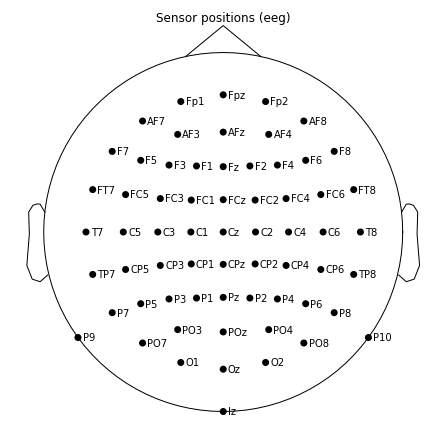

In [10]:
montage = channels.make_standard_montage(kind='biosemi64')
fig_montage = mne.viz.plot_montage(montage)

Definindo para todos os arquivos a montagem dos eletrodos, e marcando como referência o canal `Fp1`.

In [11]:
rename_ch = {k:v for k, v in zip(data_brain_vision[0].ch_names, montage.ch_names)}

for data in data_brain_vision: 
    rename_channels(data.info, rename_ch)
    data.set_montage(montage)
    data.set_eeg_reference(['Fp1'])

EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.


Filtragem passa banda com 1 - 30 Hz.

In [12]:
for data in data_brain_vision: 
    data.filter(l_freq=1, h_freq= 30, 
                fir_design = 'firwin2')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6600 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6600 s

Re-amostragem os canais de eeg para frequência de $256$ Hz. Pode ser trocado, por exemplo, para $250$ Hz. 

In [13]:
for data in data_brain_vision: 
    data.resample(256)

Limpeza dos dados com o método dos componentes independentes 

In [14]:
for data in data_brain_vision:
    ica = ICA(n_components=62, random_state=42)
    # Canais a serem utilizados no ICA
    picks = mne.pick_types(data.info,
                           eeg=True, eog=False,
                           exclude=['Fp1'])

    ica.fit(data, picks=picks, reject=dict(eeg=500e-6))
    print(ica.apply(data))

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['Cz']
Artifact detected in [9216, 9728]
    Rejecting  epoch based on EEG : ['PO4']
Artifact detected in [125440, 125952]
    Rejecting  epoch based on EEG : ['PO4']
Artifact detected in [143360, 143872]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [155648, 156160]
    Rejecting  epoch based on EEG : ['PO4']
Artifact detected in [157184, 157696]
    Rejecting  epoch based on EEG : ['P1', 'Pz']
Artifact detected in [159232, 159744]
    Rejecting  epoch based on EEG : ['Pz']
Artifact detected in [162304, 162816]
    Rejecting  epoch based on EEG : ['Pz', 'PO4']
Artifact detected in [163328, 163840]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [164352, 164864]
    Rejecting  epoch based on EEG : ['Pz']
Artifact detected in [164864, 165376]
    Rejecting  epoch based on EEG : ['Pz']
Artifact detec

Artifact detected in [115712, 116224]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [118272, 118784]
    Rejecting  epoch based on EEG : ['FC5', 'P1', 'POz']
Artifact detected in [119808, 120320]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [120832, 121344]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [121344, 121856]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [130048, 130560]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [132096, 132608]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [134144, 134656]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [150016, 150528]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [157184, 157696]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [159232, 159744]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [160768, 161280]
    Rejecting  epoch based on EEG : ['P1']
Artifact detec

Artifact detected in [107008, 107520]
    Rejecting  epoch based on EEG : ['Pz', 'CPz', 'Fpz', 'PO8', 'PO4', 'O2']
Artifact detected in [107520, 108032]
    Rejecting  epoch based on EEG : ['TP7', 'CP5']
Artifact detected in [111616, 112128]
    Rejecting  epoch based on EEG : ['CP5', 'P1', 'C4', 'T8']
Artifact detected in [112128, 112640]
    Rejecting  epoch based on EEG : ['CP5', 'T8']
Artifact detected in [112640, 113152]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C4', 'T8']
Artifact detected in [113152, 113664]
    Rejecting  epoch based on EEG : ['CP5']
Artifact detected in [113664, 114176]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'C4', 'T8']
Artifact detected in [114176, 114688]
    Rejecting  epoch based on EEG : ['CP5', 'T8']
Artifact detected in [114688, 115200]
    Rejecting  epoch based on EEG : ['CP5', 'C2', 'C4', 'T8']
Artifact detected in [115200, 115712]
    Rejecting  epoch based on EEG : ['FC5', 'P1']
Artifact detected in [115712, 116224]
    

    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'C4', 'T8']
Artifact detected in [159232, 159744]
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'C2', 'C4', 'T8']
Artifact detected in [159744, 160256]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C2', 'C4', 'T8']
Artifact detected in [160256, 160768]
    Rejecting  epoch based on EEG : ['T8']
Artifact detected in [160768, 161280]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'C2', 'C4', 'T8']
Artifact detected in [161280, 161792]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C2', 'C4']
Artifact detected in [161792, 162304]
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'C2', 'C4', 'T8']
Artifact detected in [162304, 162816]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C4', 'T8']
Artifact detected in [162816, 163328]
    Rejecting  epoch based on EEG : ['CP5', 'C2', 'C4']
Artifact detected in [163328, 163840]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C4', 'T8']
Artifac

Artifact detected in [202240, 202752]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'P1', 'C2', 'C4', 'T8']
Artifact detected in [202752, 203264]
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'C2', 'C4']
Artifact detected in [203264, 203776]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C2', 'C4', 'T8']
Artifact detected in [203776, 204288]
    Rejecting  epoch based on EEG : ['TP7']
Artifact detected in [205312, 205824]
    Rejecting  epoch based on EEG : ['TP7', 'C2']
Artifact detected in [206336, 206848]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'C2', 'C4', 'T8']
Artifact detected in [206848, 207360]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'P1', 'C2', 'C4', 'T8']
Artifact detected in [207360, 207872]
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'C2', 'T8']
Artifact detected in [207872, 208384]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'P1', 'C2', 'C4', 'T8']
Artifact detected in [208384, 208896]
   

Artifact detected in [124416, 124928]
    Rejecting  epoch based on EEG : ['P1', 'Pz', 'CPz', 'Fpz', 'PO8', 'PO4', 'O2']
Artifact detected in [128000, 128512]
    Rejecting  epoch based on EEG : ['TP7', 'P1', 'C4']
Artifact detected in [128512, 129024]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'P1']
Artifact detected in [129024, 129536]
    Rejecting  epoch based on EEG : ['TP7']
Artifact detected in [129536, 130048]
    Rejecting  epoch based on EEG : ['P1']
Artifact detected in [130048, 130560]
    Rejecting  epoch based on EEG : ['FC5', 'P1']
Artifact detected in [130560, 131072]
    Rejecting  epoch based on EEG : ['P1', 'C4']
Artifact detected in [131072, 131584]
    Rejecting  epoch based on EEG : ['FC5']
Artifact detected in [131584, 132096]
    Rejecting  epoch based on EEG : ['P1', 'C4']
Artifact detected in [132096, 132608]
    Rejecting  epoch based on EEG : ['P1', 'C4']
Artifact detected in [133120, 133632]
    Rejecting  epoch based on EEG : ['P1', 'C4']
Artifact 

Artifact detected in [202752, 203264]
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5', 'P1', 'C4']
Artifact detected in [203776, 204288]
    Rejecting  epoch based on EEG : ['T7', 'TP7', 'CP5', 'C2', 'C4']
Artifact detected in [204800, 205312]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C4']
Artifact detected in [205312, 205824]
    Rejecting  epoch based on EEG : ['CP5', 'C2', 'C4']
Artifact detected in [205824, 206336]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'C4']
Artifact detected in [206336, 206848]
    Rejecting  epoch based on EEG : ['CP5', 'C2', 'C4']
Artifact detected in [206848, 207360]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'CPz', 'C4']
Artifact detected in [207360, 207872]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P1', 'C2', 'C4']
Artifact detected in [208384, 208896]
    Rejecting  epoch based on EEG : ['FC5']
Artifact detected in [208896, 209408]
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'C2', 'C4']
Artifact d

Artifact detected in [249344, 249856]
    Rejecting  epoch based on EEG : ['P1', 'T8', 'PO4']
Artifact detected in [249856, 250368]
    Rejecting  epoch based on EEG : ['FC5', 'C1', 'CP5', 'P1', 'P5', 'C4']
Artifact detected in [250368, 250880]
    Rejecting  epoch based on EEG : ['FC5', 'C2']
Artifact detected in [250880, 251392]
    Rejecting  epoch based on EEG : ['TP7', 'CP5', 'C2', 'C4', 'T8']
Artifact detected in [251392, 251904]
    Rejecting  epoch based on EEG : ['FC5', 'C1', 'CP5', 'P1', 'P5', 'C4']
Artifact detected in [251904, 252416]
    Rejecting  epoch based on EEG : ['C2']
Artifact detected in [252416, 252928]
    Rejecting  epoch based on EEG : ['FC5', 'C1', 'TP7', 'CP5', 'P1', 'P5', 'C2', 'C4']
Artifact detected in [252928, 253440]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'P1']
Artifact detected in [256512, 257024]
    Rejecting  epoch based on EEG : ['FC5', 'TP7', 'CP5', 'P1']
Artifact detected in [257024, 257536]
    Rejecting  epoch based on EEG : 

Epocamento dos dados, com base nas anotações de tempo para os arremessos.

In [15]:
events, event_name = mne.events_from_annotations(data_brain_vision[0], verbose=True)

epochs = mne.Epochs(data_brain_vision[0], events, event_name,
                    tmin = 0, tmax = tmax[0], detrend = 0, preload=True, baseline=(0,0))

Used Annotations descriptions: ['100_arre', '40_arre', '60_arre', '80_arre']
4 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 4 events and 26113 original time points ...
0 bad epochs dropped


Conectividade dos canais.


In [16]:
from mne.connectivity import spectral_connectivity

from mne.viz import plot_sensors_connectivity

In [20]:
# Para analise de conectividade pode-se analisar por bandas específicas.
# Nesse momento analisamos toda a faixa disponível.
fmin, fmax = 0.1, 256.
sfreq = data_brain_vision[0].info['sfreq'] 
tmin = 0.0  
con_methods = ['coh','pli', 'wpli2_debiased', 'ciplv']


con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs, method='coh', mode='fourier', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=False, tmin=tmin, n_jobs=-1)


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..102.000s for estimation (26113 points)
    frequencies: 0.1Hz..128.0Hz (13046 points)
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    computing connectivity for epochs 2..2


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    computing connectivity for epochs 3..3


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    computing connectivity for epochs 4..4


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.3s finished


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


In [22]:
np.array(con).shape

(64, 64, 13046)

Continuar logo mais.